<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [175]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# modeling
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold, learning_curve
from sklearn.preprocessing import scale, MinMaxScaler, normalize
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter, OrderedDict


from time import sleep, time
from sklearn.grid_search import GridSearchCV

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [176]:
business = pd.read_csv('../../datasets/yelp_arizona_data/businesses_small_parsed.csv')
checkins = pd.read_csv('../../datasets/yelp_arizona_data/checkins_small_parsed.csv')
reviews = pd.read_csv('../../datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('../../datasets/yelp_arizona_data/tips_small_nlp_parsed.csv')
users = pd.read_csv('../../datasets/yelp_arizona_data/users_small_parsed.csv')

In [177]:
print business.shape
print business.columns

business.head()

(152832, 11)
Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value'],
      dtype='object')


,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",33.455885,-112.074177,[],attributes.Ambience.divey,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']",33.452154,-112.068620,[],attributes.Ambience.divey,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"['Fast Food', 'Mexican', 'Tex-Mex', 'Restauran...",33.465440,-112.069090,[],attributes.Ambience.divey,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"['Bars', 'Restaurants', 'American (Traditional...",33.448465,-112.071257,[],attributes.Ambience.divey,False


In [178]:
business.dtypes

business_id       object
name              object
review_count       int64
city              object
stars            float64
categories        object
latitude         float64
longitude        float64
neighborhoods     object
variable          object
value             object
dtype: object

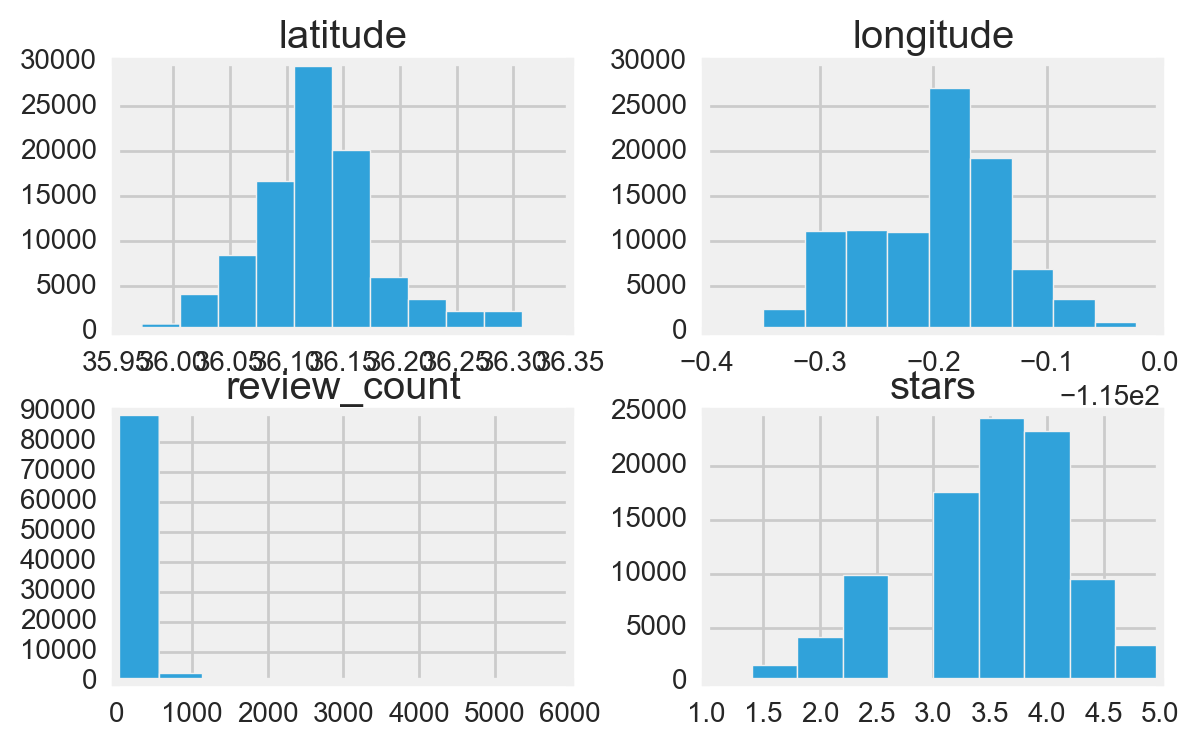

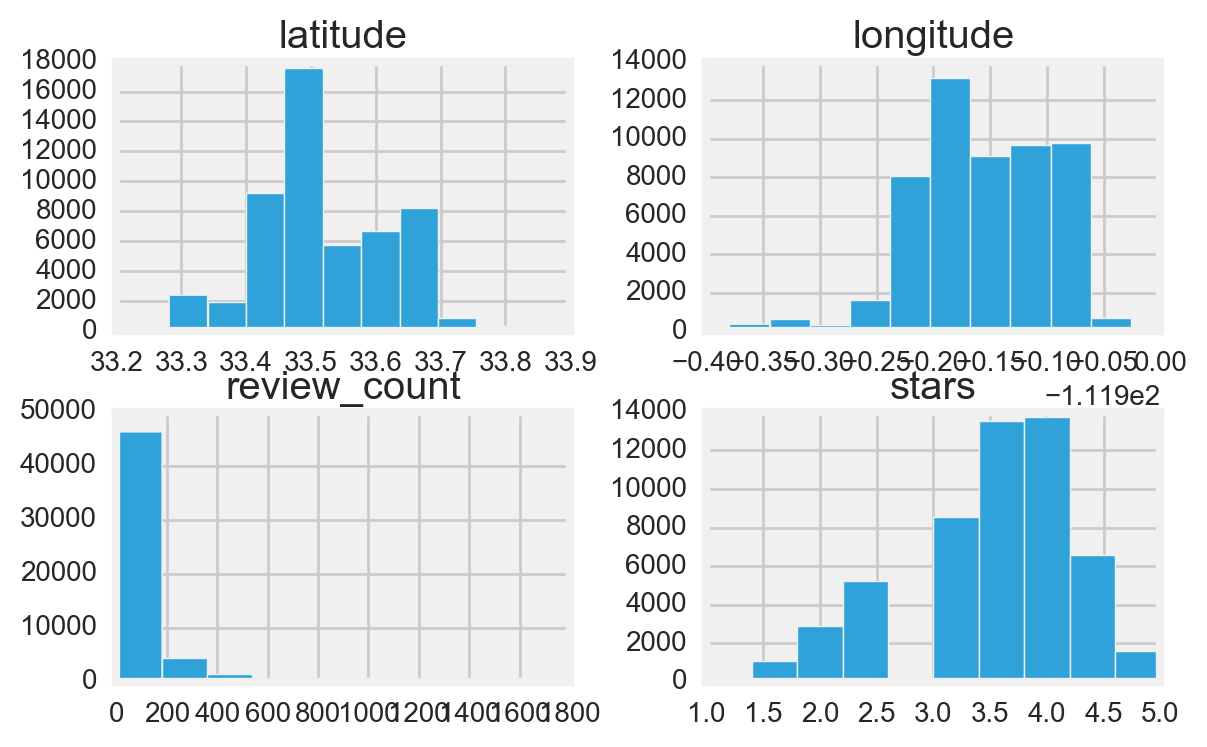

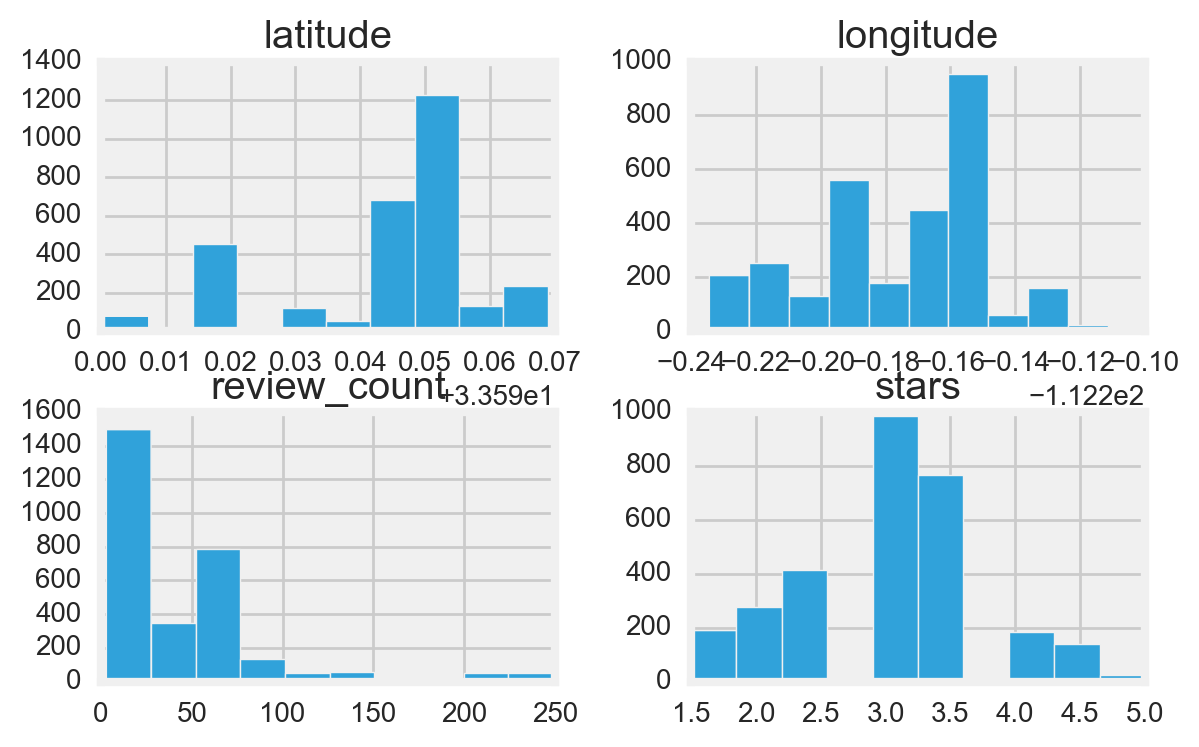

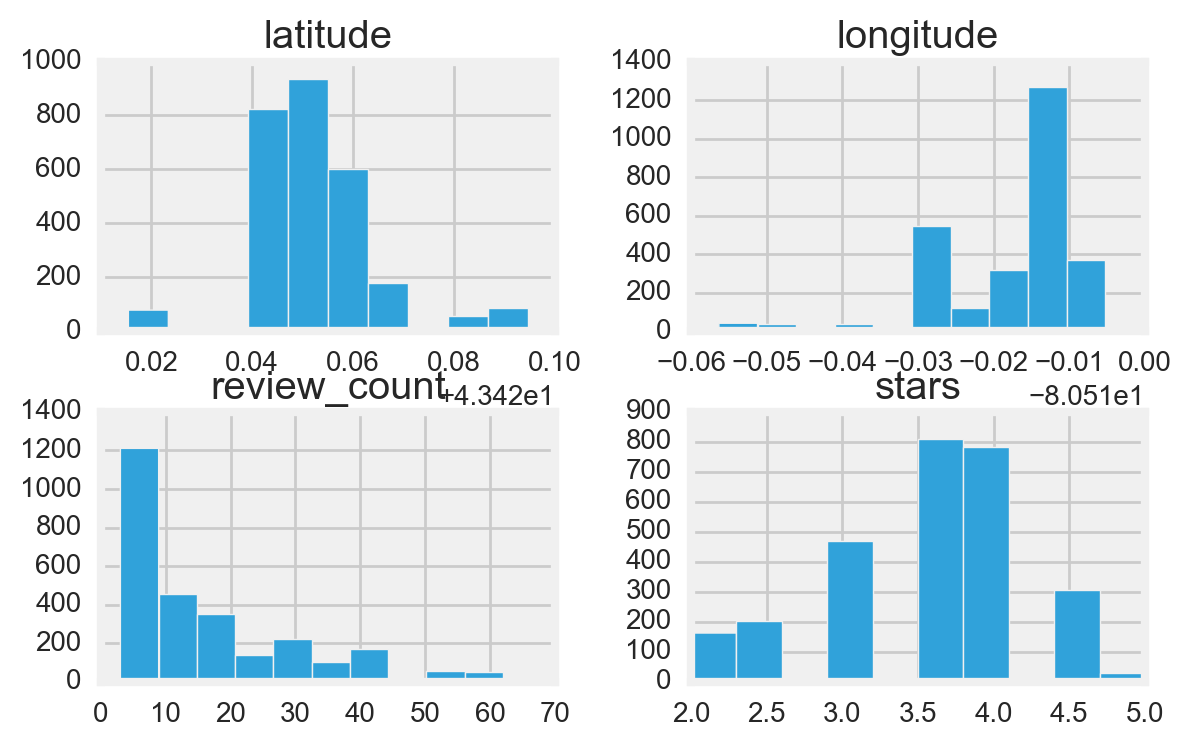

In [179]:
business.groupby("city").hist();

In [180]:
categories = business.categories.apply(eval)
business_copy = business.copy()
business_copy['categories'] = categories
#unique_categories = set(list(itertools.chain(*categories.tolist())))

In [181]:
#simplified list of categories
given_cats = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

    
for cat in given_cats:
    business_copy[cat] = business_copy['categories'].apply(lambda x: cat in x)



In [182]:
business_copy.head()

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"[American (New), Nightlife, Dance Clubs, Resta...",33.448399,-112.071702,[],attributes.Ambience.divey,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"[Bars, Nightlife, Dance Clubs]",33.455885,-112.074177,[],attributes.Ambience.divey,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"[Cafes, Mexican, Tex-Mex, Restaurants]",33.452154,-112.068620,[],attributes.Ambience.divey,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"[Fast Food, Mexican, Tex-Mex, Restaurants]",33.465440,-112.069090,[],attributes.Ambience.divey,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"[Bars, Restaurants, American (Traditional), Sp...",33.448465,-112.071257,[],attributes.Ambience.divey,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [183]:
business_copy.columns[-17:]

Index([u'Airports', u'Breakfast & Brunch', u'Bubble Tea', u'Burgers', u'Bars',
       u'Bakeries', u'Breweries', u'Cafes', u'Candy Stores', u'Comedy Clubs',
       u'Courthouses', u'Dance Clubs', u'Fast Food', u'Museums', u'Tattoo',
       u'Vape Shops', u'Yoga'],
      dtype='object')

In [184]:
business_copy.groupby("city")[business_copy.columns[-17:]].mean()

,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
city,,,,,,,,,,,,,,,,,
Las Vegas,0.000203,0.103754,0.006896,0.150142,0.394199,0.050555,0.009145,0.061140,0.006523,0.010254,0.000043,0.039502,0.253960,0.003837,0.016671,0.018792,0.005351
Phoenix,0.000657,0.166482,0.002759,0.188085,0.341598,0.066649,0.010098,0.063759,0.004580,0.003698,0.000075,0.017249,0.264832,0.005650,0.008990,0.011524,0.011693
Surprise,0.000000,0.118359,0.000000,0.271015,0.352724,0.058507,0.000000,0.026900,0.007397,0.000000,0.000000,0.037660,0.339274,0.000000,0.000000,0.018494,0.000000
Waterloo,0.000000,0.101413,0.000000,0.216950,0.406737,0.070627,0.026078,0.137631,0.000000,0.000000,0.000000,0.019196,0.268743,0.000000,0.008330,0.000000,0.000000


In [185]:
business_copy.isnull().sum()
# business_copy isn't missing any values

business_id           0
name                  0
review_count          0
city                  0
stars                 0
categories            0
latitude              0
longitude             0
neighborhoods         0
variable              0
value                 0
Airports              0
Breakfast & Brunch    0
Bubble Tea            0
Burgers               0
Bars                  0
Bakeries              0
Breweries             0
Cafes                 0
Candy Stores          0
Comedy Clubs          0
Courthouses           0
Dance Clubs           0
Fast Food             0
Museums               0
Tattoo                0
Vape Shops            0
Yoga                  0
dtype: int64

In [186]:
print tips.shape, tips.columns
tips.head()

(101991, 104) Index([u'user_id', u'business_id', u'likes', u'date', u'24 hours',
       u'amazing food', u'animal style', u'awesome food', u'awesome place',
       u'awesome service',
       ...
       u'service good', u'service great', u'slow service', u'staff friendly',
       u'staff great', u'steak eggs', u'super friendly', u'sweet potato',
       u'velvet pancakes', u'worth wait'],
      dtype='object', length=104)


,user_id,business_id,likes,date,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,best burger,best burgers,best place,bloody mary,bottle service,carne asada,cheese fries,chicken waffles,come early,cool place,corned beef,customer service,delicious food,don come,don forget,eggs benedict,excellent food,excellent service,fast food,fast service,favorite place,feel like,fish chips,food amazing,food awesome,food drinks,food good,food great,food service,free wifi,french toast,fried chicken,friendly service,friendly staff,gluten free,good food,good place,good service,great atmosphere,great beer,great breakfast,great burgers,great customer,great drinks,great food,great happy,great place,great prices,great service,great spot,great staff,grilled cheese,guest list,happy birthday,happy hour,highly recommend,ice cream,las vegas,late night,live music,long wait,love food,love love,love place,mac cheese,make sure,new favorite,nice place,nom nom,onion rings,open 24,place awesome,place eat,place good,place great,potato fries,pretty good,prime rib,really good,red velvet,service food,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
0,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,liIQCDzDTnvXc7X8twBIjg,EmzaQR5hQlF0WIl24NxAZA,0,2013-04-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,iW1ltQqq4GWAErobLiOv9w,EmzaQR5hQlF0WIl24NxAZA,0,2013-08-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,wiBTgZNmDKHDgeuKSxIMjQ,SiwN7f0N4bs4ZtPc4yPgiA,0,2011-02-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,wiBTgZNmDKHDgeuKSxIMjQ,SiwN7f0N4bs4ZtPc4yPgiA,0,2011-02-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [187]:
print reviews.columns, reviews.shape
reviews.head()

Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       ...
       u'service great', u'staff friendly', u'super friendly', u'sweet potato',
       u'tasted like', u'time vegas', u'try place', u've seen', u've tried',
       u'wait staff'],
      dtype='object', length=108) (322398, 108)


,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,bar food,beer selection,best ve,bloody mary,bottle service,chicken waffles,customer service,dance floor,decided try,definitely come,definitely recommend,didn want,don know,don like,don think,don want,eggs benedict,fast food,feel like,felt like,fish chips,food amazing,food came,food delicious,food good,food great,food just,food service,french fries,french toast,friday night,fried chicken,friendly staff,good food,good place,good service,good thing,good time,great atmosphere,great experience,great food,great place,great service,great time,happy hour,hash browns,highly recommend,hip hop,ice cream,just like,just ok,just right,las vegas,late night,like place,little bit,long time,looked like,looks like,love place,mac cheese,make sure,mashed potatoes,medium rare,minutes later,new york,onion rings,place good,place great,place just,potato fries,pretty good,quality food,really enjoyed,really good,really like,really nice,recommend place,red velvet,right away,saturday night,second time,service excellent,service food,service friendly,service good,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [188]:
print users.shape, users.columns
users.head()

(144206, 21) Index([u'yelping_since', u'compliments.plain', u'review_count',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')


,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,3.66,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,3.60,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,3.80,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,3.58,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,4.02,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


In [189]:
tips_nlp_means = tips.groupby("business_id")[tips.columns[-100:]].mean()

In [190]:
df = pd.merge(business_copy, tips_nlp_means, left_on="business_id", right_index=True, how="left")

In [191]:
print str(business_copy.shape) + " --> " + str(df.shape)
# Added 100 rows of mean sentiment phrases 

(152832, 28) --> (152832, 128)


In [192]:
df_clean = df.drop(["business_id", "categories", "latitude", "longitude", "neighborhoods"], axis=1)
df_clean.tail(200)

,name,review_count,city,stars,variable,value,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,best burger,best burgers,best place,bloody mary,bottle service,carne asada,cheese fries,chicken waffles,come early,cool place,corned beef,customer service,delicious food,don come,don forget,eggs benedict,excellent food,excellent service,fast food,fast service,favorite place,feel like,fish chips,food amazing,food awesome,food drinks,food good,food great,food service,free wifi,french toast,fried chicken,friendly service,friendly staff,gluten free,good food,good place,good service,great atmosphere,great beer,great breakfast,great burgers,great customer,great drinks,great food,great happy,great place,great prices,great service,great spot,great staff,grilled cheese,guest list,happy birthday,happy hour,highly recommend,ice cream,las vegas,late night,live music,long wait,love food,love love,love place,mac cheese,make sure,new favorite,nice place,nom nom,onion rings,open 24,place awesome,place eat,place good,place great,potato fries,pretty good,prime rib,really good,red velvet,service food,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
152632,Linger Longer Lounge,45,Phoenix,4.0,attributes.Ambience.upscale,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.000000,0.0,0.000000,0.10,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.100000,0.0,0.000000,0.0,0.0,0.0,0.0,0.100000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,0.100000,0.0,0.000000,0.100000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.100000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.1,0.0,0.200000,0.100000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.100000,0.10,0.0,0.000000,0.000000,0.00000,0.0,0.000000
152633,The Corner CityScape,49,Phoenix,3.5,attributes.Ambience.upscale,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00000,0.0,0.000000
152634,ALIBI Ultra Lounge,65,Las Vegas,3.0,attributes.Ambience.upscale,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.166667,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0

In [193]:
(df_clean.isnull().sum()/df_clean.shape[0]).sort_values(ascending=False).head()

worth wait           0.052181
food good            0.052181
excellent food       0.052181
excellent service    0.052181
fast food            0.052181
dtype: float64

In [194]:
# This is unfortunate, every single row has a null value.  From the check above, we know that these null values
# must be in the 100 columns added. 
print df_clean.shape, df_clean.isnull().shape

(152832, 123) (152832, 123)


In [195]:
# Iterate through these rows and replace null values with 0
for col in df_clean.columns[-100:]:
    df_clean[col].fillna(0, inplace=True, axis=0)

In [196]:
# Successfully replaced null values in these "Tip Mean columns"
df_clean.isnull().sum().tail()

steak eggs         0
super friendly     0
sweet potato       0
velvet pancakes    0
worth wait         0
dtype: int64

In [197]:
df_clean.head()

,name,review_count,city,stars,variable,value,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,best burger,best burgers,best place,bloody mary,bottle service,carne asada,cheese fries,chicken waffles,come early,cool place,corned beef,customer service,delicious food,don come,don forget,eggs benedict,excellent food,excellent service,fast food,fast service,favorite place,feel like,fish chips,food amazing,food awesome,food drinks,food good,food great,food service,free wifi,french toast,fried chicken,friendly service,friendly staff,gluten free,good food,good place,good service,great atmosphere,great beer,great breakfast,great burgers,great customer,great drinks,great food,great happy,great place,great prices,great service,great spot,great staff,grilled cheese,guest list,happy birthday,happy hour,highly recommend,ice cream,las vegas,late night,live music,long wait,love food,love love,love place,mac cheese,make sure,new favorite,nice place,nom nom,onion rings,open 24,place awesome,place eat,place good,place great,potato fries,pretty good,prime rib,really good,red velvet,service food,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
0,Sky Lounge,25,Phoenix,2.5,attributes.Ambience.divey,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Palazzo,19,Phoenix,3.0,attributes.Ambience.divey,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,Canyon Cafe,238,Phoenix,3.5,attributes.Ambience.divey,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0,0.021277,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.000000,0.0,0.021277,0.021277,0.0,0.0,0.0,0.0,0.127660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.021277,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,0.021277,0.0,0.0
3,Taco Bell,10,Phoenix,4.0,attributes.Ambience.divey,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,

In [198]:
df_clean.drop(["name", "value"], axis=1, inplace=True)

In [199]:
df_clean["city"] = df_clean["city"].apply(lambda x: 1 if x == "Las Vegas" else 0)

In [200]:
df_clean.city.value_counts()

1    93818
0    59014
Name: city, dtype: int64

In [201]:
df_clean["stars"] = df_clean["stars"].astype(float)

In [202]:
dummies = (pd.get_dummies(df_clean["variable"]))
df_tips_dummies = pd.merge(df_clean, dummies, left_index=True, right_index=True)

In [203]:
df_tips_dummies.head()

,review_count,city,stars,variable,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,best burger,best burgers,best place,bloody mary,bottle service,carne asada,cheese fries,chicken waffles,come early,cool place,corned beef,customer service,delicious food,don come,don forget,eggs benedict,excellent food,excellent service,fast food,fast service,favorite place,feel like,fish chips,food amazing,food awesome,food drinks,food good,food great,food service,free wifi,french toast,fried chicken,friendly service,friendly staff,gluten free,good food,good place,good service,great atmosphere,great beer,great breakfast,great burgers,great customer,great drinks,great food,great happy,great place,great prices,great service,great spot,great staff,grilled cheese,guest list,happy birthday,happy hour,highly recommend,ice cream,las vegas,late night,live music,long wait,love food,love love,love place,mac cheese,make sure,new favorite,nice place,nom nom,onion rings,open 24,place awesome,place eat,place good,place great,potato fries,pretty good,prime rib,really good,red velvet,service food,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.Attire,attributes.BYOB,attributes.BYOB/Corkage,attributes.By Appointment Only,attributes.Caters,attributes.Coat Check,attributes.Corkage,attributes.Delivery,attributes.Dietary Restrictions.dairy-free,attributes.Dietary Restrictions.gluten-free,attributes.Dietary Restrictions.halal,attributes.Dietary Restrictions.kosher,attributes.Dietary Restrictions.soy-free,attributes.Dietary Restrictions.vegan,attributes.Dietary Restrictions.vegetarian,attributes.Dogs Allowed,attributes.Drive-Thru,attributes.Good For Dancing,attributes.Good For Groups,attributes.Good For.breakfast,attributes.Good For.brunch,attributes.Good For.dessert,attributes.Good For.dinner,attributes.Good For.latenight,attributes.Good For.lunch,attributes.Good for Kids,attributes.Happy Hour,attributes.Has TV,attributes.Music.background_music,attributes.Music.dj,attributes.Music.jukebox,attributes.Music.karaoke,attributes.Music.live,attributes.Music.video,attributes.Noise Level,attributes.Open 24 Hours,attributes.Order at Counter,attributes.Outdoor Seating,attributes.Parking.garage,attributes.Parking.lot,attributes.Parking.street,attributes.Parking.valet,attributes.Parking.validated,attributes.Price Range,attributes.Smoking,attributes.Take-out,attributes.Takes Reservations,attributes.Waiter Service,attributes.Wheelchair Accessible,attributes.Wi-Fi,hours.Friday.close,hours.Friday.open,hours.Monday.close,hours.Monday.open,hours.Saturday.close,hours.Saturday.open,hours.Sunday.close,hours.Sunday.open,hours.Thursday.close,hours.Thursday.open,hours.Tuesday.close,hours.Tuesday.open,hours.Wednesday.close,hours.Wednesday.open,open
0,25,0,2.5,attributes.Ambience.divey,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.

In [204]:
# Drop more uneccessary columns
df_tips_dummies.drop(["variable","open"], axis=1, inplace=True)

In [205]:
# Change boolean columns to floats
for col in df_tips_dummies.columns[3:20]:
    df_tips_dummies[col] = df_tips_dummies[col].astype(float)

In [206]:
# working with all numerical now
df_tips_dummies.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [207]:
# Scale the data
df_scaled = df_tips_dummies.apply(lambda x: MinMaxScaler(feature_range=(0,1)).fit_transform(x));

/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

In [208]:
df_scaled.head()

,review_count,city,stars,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,best burger,best burgers,best place,bloody mary,bottle service,carne asada,cheese fries,chicken waffles,come early,cool place,corned beef,customer service,delicious food,don come,don forget,eggs benedict,excellent food,excellent service,fast food,fast service,favorite place,feel like,fish chips,food amazing,food awesome,food drinks,food good,food great,food service,free wifi,french toast,fried chicken,friendly service,friendly staff,gluten free,good food,good place,good service,great atmosphere,great beer,great breakfast,great burgers,great customer,great drinks,great food,great happy,great place,great prices,great service,great spot,great staff,grilled cheese,guest list,happy birthday,happy hour,highly recommend,ice cream,las vegas,late night,live music,long wait,love food,love love,love place,mac cheese,make sure,new favorite,nice place,nom nom,onion rings,open 24,place awesome,place eat,place good,place great,potato fries,pretty good,prime rib,really good,red velvet,service food,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.Attire,attributes.BYOB,attributes.BYOB/Corkage,attributes.By Appointment Only,attributes.Caters,attributes.Coat Check,attributes.Corkage,attributes.Delivery,attributes.Dietary Restrictions.dairy-free,attributes.Dietary Restrictions.gluten-free,attributes.Dietary Restrictions.halal,attributes.Dietary Restrictions.kosher,attributes.Dietary Restrictions.soy-free,attributes.Dietary Restrictions.vegan,attributes.Dietary Restrictions.vegetarian,attributes.Dogs Allowed,attributes.Drive-Thru,attributes.Good For Dancing,attributes.Good For Groups,attributes.Good For.breakfast,attributes.Good For.brunch,attributes.Good For.dessert,attributes.Good For.dinner,attributes.Good For.latenight,attributes.Good For.lunch,attributes.Good for Kids,attributes.Happy Hour,attributes.Has TV,attributes.Music.background_music,attributes.Music.dj,attributes.Music.jukebox,attributes.Music.karaoke,attributes.Music.live,attributes.Music.video,attributes.Noise Level,attributes.Open 24 Hours,attributes.Order at Counter,attributes.Outdoor Seating,attributes.Parking.garage,attributes.Parking.lot,attributes.Parking.street,attributes.Parking.valet,attributes.Parking.validated,attributes.Price Range,attributes.Smoking,attributes.Take-out,attributes.Takes Reservations,attributes.Waiter Service,attributes.Wheelchair Accessible,attributes.Wi-Fi,hours.Friday.close,hours.Friday.open,hours.Monday.close,hours.Monday.open,hours.Saturday.close,hours.Saturday.open,hours.Sunday.close,hours.Sunday.open,hours.Thursday.close,hours.Thursday.open,hours.Tuesday.close,hours.Tuesday.open,hours.Wednesday.close,hours.Wednesday.open
0,0.003901,0.0,0.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [209]:
df_scaled.columns

Index([u'review_count', u'city', u'stars', u'Airports', u'Breakfast & Brunch',
       u'Bubble Tea', u'Burgers', u'Bars', u'Bakeries', u'Breweries',
       ...
       u'hours.Saturday.close', u'hours.Saturday.open', u'hours.Sunday.close',
       u'hours.Sunday.open', u'hours.Thursday.close', u'hours.Thursday.open',
       u'hours.Tuesday.close', u'hours.Tuesday.open', u'hours.Wednesday.close',
       u'hours.Wednesday.open'],
      dtype='object', length=197)

In [210]:
# Create X and Y 

x_cols = df_scaled.columns
x_cols = x_cols.drop("city")
X = df_scaled[x_cols].values

Y = df_scaled.city.values
Y.mean()
# 61% of columns are Las Vegas.  Going to test accuracy without balancing classes, 
# since this is close enough to %50

0.61386358877721947

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=.8)


In [ ]:
lr = LogisticRegression(penalty='l2')

scores = cross_val_score(lr, X, Y, cv=10, n_jobs=-1)
print "Cross validated accuracy scores: \n" + str(scores)

In [ ]:
np.mean(scores)

In [ ]:
lr.fit(x_train, y_train)
y_pred1 = lr.predict(x_test)

In [ ]:
print "Logistic Regression"
print "Accuracy: " + str(accuracy_score(y_test, y_pred1))
print "Precision: " + str(precision_score(y_test, y_pred1))
print "Recall: " + str(recall_score(y_test, y_pred1))
print "F1 Score: " + str(f1_score(y_test, y_pred1))

In [ ]:
# Now testing a Random Forest
rf = RandomForestClassifier()

scores2 = cross_val_score(rf, X, Y, cv=10, n_jobs=-1)

In [ ]:
# Looks like a good candidate
print "Cross validated accuracy scores: \n" + str(scores2)

In [ ]:
np.mean(scores2)

In [ ]:
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [ ]:
y_pred

In [ ]:
print "Random Forest Classifier"
print "Accuracy: " + str(accuracy_score(y_test, y_pred))
print "Precision: " + str(precision_score(y_test, y_pred))
print "Recall: " + str(recall_score(y_test, y_pred))
print "F1 Score: " + str(f1_score(y_test, y_pred))

In [ ]:
# This model performed very well on the testing data set across all metrics.  Let's get the features: 
feature_importance = sorted(zip(rf.feature_importances_, x_cols), reverse=True)
feature_importance

In [ ]:
top_15_features = feature_importance[:15]
feature_name = []
feature_value = []

for feature in top_15_features:
    feature_name.append(feature[1])
    feature_value.append(int(feature[0]*1000))

ft = pd.DataFrame(index=feature_name, data=feature_value)
ft.plot(kind="bar",figsize=(12,7),color="teal", title="Top 15 Predictors of Las Vegas");

# Results

By using a RandomForest Classifier, we built a model that was used to predict if a yelp business is located in Las Vegas based on 196 features.  The model tested on unseen data with accuracy metrics above 90%, confirming that this model has a high predictive power.  The results indicate that based on on data from Las Vegas and three other cities, Phoenix, Waterloo, and Suprise, Las Vegas businesses are best predicted by the number of reviews on its yelp page.  Followed by the actual star count, rating, which suggests slightly higher quality or well-liked businesses.  Interestingly, the language-processed term las vegas in tips associated with the business was the third best predictor of las vegas, which makes sense.  Followed by the features shown above.  

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [50]:
# Divide Reviews into service and non-service focused groups
reviews.head()

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
reviews.columns

Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       ...
       u'service great', u'staff friendly', u'super friendly', u'sweet potato',
       u'tasted like', u'time vegas', u'try place', u've seen', u've tried',
       u'wait staff'],
      dtype='object', length=108)

In [52]:
# 322,398 rows
reviews.shape

(322398, 108)

In [53]:
service_based_reviews = \
reviews[(reviews["customer service"]==1) |
        (reviews["food service"]==1) |
        (reviews["friendly staff"]==1) |
        (reviews["good service"]==1) |
        (reviews["good place"]==1) |
        (reviews["food service"]==1) |
        (reviews["great experience"]==1) |
        (reviews["great service"]==1) |
        (reviews["great time"]==1) |
        (reviews["long time"]==1)|
        (reviews["minutes later"]==1) |
        (reviews["right away"]==1) |
        (reviews["service excellent"]==1) |
        (reviews["service friendly"]==1) |
        (reviews["service good"]==1)|
        (reviews["service great"]==1) |
        (reviews["staff friendly"]==1) |
        (reviews["super friendly"]==1) ]

service_based_reviews.shape

(68132, 108)

In [54]:
non_service_based_reviews = \
reviews[~((reviews["customer service"]==1) |
        (reviews["food service"]==1) |
        (reviews["friendly staff"]==1) |
        (reviews["good service"]==1) |
        (reviews["good place"]==1) |
        (reviews["food service"]==1) |
        (reviews["great experience"]==1) |
        (reviews["great service"]==1) |
        (reviews["great time"]==1) |
        (reviews["long time"]==1)|
        (reviews["minutes later"]==1) |
        (reviews["right away"]==1) |
        (reviews["service excellent"]==1) |
        (reviews["service friendly"]==1) |
        (reviews["service good"]==1)|
        (reviews["service great"]==1) |
        (reviews["staff friendly"]==1) |
        (reviews["super friendly"]==1)) ]

non_service_based_reviews.shape

(254266, 108)

In [55]:
# Create two new ratings for businesses..
# From Service Based Reviews
businesses_sr = service_based_reviews.groupby("business_id")[["stars"]].mean()
businesses_sr.rename(columns={"stars":"service rating"}, inplace=True)
businesses_sr.head()

,service rating
business_id,
--jFTZmywe7StuZ2hEjxyA,3.000000
-0HGqwlfw3I8nkJyMHxAsQ,3.500000
-1bOb2izeJBZjHC7NWxiPA,4.119048
-2_O3_WKgO5In5XO5extNQ,4.666667
-2k6VTGx1M93hscEdhx37A,4.200000


In [56]:
businesses_sr["service rating"].mean()

3.7340207669256533

In [57]:
businesses_nsr = non_service_based_reviews.groupby("business_id")[["stars"]].mean()
businesses_nsr.rename(columns={"stars":"non-service rating"}, inplace=True)
businesses_nsr.head()

,non-service rating
business_id,
--jFTZmywe7StuZ2hEjxyA,4.000000
-0HGqwlfw3I8nkJyMHxAsQ,2.857143
-0VK5Z1BfUHUYq4PoBYNLw,3.750000
-0bUDim5OGuv8R0Qqq6J4A,2.142857
-1bOb2izeJBZjHC7NWxiPA,3.923077


In [58]:
businesses_nsr["non-service rating"].mean()

3.427431724457765

In [59]:
businesses = reviews.groupby("business_id")[["stars"]].mean()
businesses.head()

,stars
business_id,
--jFTZmywe7StuZ2hEjxyA,3.400000
-0HGqwlfw3I8nkJyMHxAsQ,3.000000
-0VK5Z1BfUHUYq4PoBYNLw,3.750000
-0bUDim5OGuv8R0Qqq6J4A,2.142857
-1bOb2izeJBZjHC7NWxiPA,4.000000


In [60]:
# Merge dataframes of ratings (general, service, non-service)
ratings = pd.merge(businesses, businesses_sr, how="inner", left_index=True, right_index=True)
ratings = pd.merge(ratings, businesses_nsr, how="inner", left_index=True, right_index=True)
ratings.head()

,stars,service rating,non-service rating
business_id,,,
--jFTZmywe7StuZ2hEjxyA,3.400000,3.000000,4.000000
-0HGqwlfw3I8nkJyMHxAsQ,3.000000,3.500000,2.857143
-1bOb2izeJBZjHC7NWxiPA,4.000000,4.119048,3.923077
-2_O3_WKgO5In5XO5extNQ,4.900000,4.666667,4.941176
-2k6VTGx1M93hscEdhx37A,4.384615,4.200000,4.500000


In [61]:
reviews_3ratings = pd.merge(reviews, ratings, how="inner", left_on="business_id", right_index=True)
reviews_3ratings

,user_id,review_id,votes.cool,business_id,votes.funny,stars_x,date,votes.useful,10 minutes,15 minutes,...,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff,stars_y,service rating,non-service rating
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,2.400000,4.000000,2.181818
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,2.400000,4.000000,2.181818
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,2.400000,4.000000,2.181818
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,2.400000,4.000000,2.181818
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,2.400000,4.000000,2.181818
5,TR2YFVnIM5UM38RuMy6dcw,HUbubdE18goGYElee83hMw,0,EmzaQR5hQlF0WIl24NxAZA,0,5,2011-04-17,1,0,0,...,0,0,0,0,0,0,0,2.400000,4.000000,2.181818
6,trdsekNRD-gIs50EBrScwA,XFJ7N6UDMwCUR-WvFzADPg,0,EmzaQR5hQlF0WIl24NxAZA,0,4,2012-02-27,0,0,0,...,0,0,0,0,0,0,0,2.400000,4.000000,2.181818
7,PnsKyueIKIIimnRGo0niWw,oOYyD6oLLKPm-lj9H9whSw,0,EmzaQR5hQlF0WIl24NxAZA,1,2,2012-10-02,1,0,1,...,0,0,0,0,0,0,0,2.400000,4.000000,2.181818
8,8leVoQakIF9OfyikF7Yu5g,WwWdhzdTyef9vFBIQhm1Pw,0,EmzaQR5hQlF0WIl24NxAZA,1,1,2013-02-16,4,0,0,...,0,0,0,0,0,0,0,2.400000,4.000000,2.181818
9,lGROEmEZaINjHghhViWdeQ,C85618PrjV1lUBUyWaFksA,0,EmzaQR5hQlF0WIl24NxAZA,0,1,2013-04-12,4,0,0,...,0,0,0,0,0,0,0,2.400000,4.000000,2.181818


In [62]:
#Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice).
#Validate the performance of the models.
#Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [63]:
reviews_3ratings.drop(["user_id","review_id","business_id","date"], axis=1, inplace=True)

In [64]:
reviews_3ratings.shape
# 318,475 rows with 106 columns, 3 of which are ratings

(318475, 107)

In [65]:
reviews_3ratings.head()

,votes.cool,votes.funny,stars_x,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,bar food,beer selection,...,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff,stars_y,service rating,non-service rating
0,0,0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.4,4.0,2.181818
1,3,12,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.4,4.0,2.181818
2,0,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.4,4.0,2.181818
3,4,9,2,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.4,4.0,2.181818
4,0,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.4,4.0,2.181818


In [66]:
reviews_3ratings = reviews_3ratings.apply(lambda x: MinMaxScaler(feature_range=(0,1)).fit_transform(x));

/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

In [67]:
reviews_3ratings.head()

,votes.cool,votes.funny,stars_x,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,bar food,beer selection,...,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff,stars_y,service rating,non-service rating
0,0.000000,0.000000,0.50,0.007092,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35,0.75,0.295455
1,0.021898,0.093023,0.25,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35,0.75,0.295455
2,0.000000,0.015504,0.25,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35,0.75,0.295455
3,0.029197,0.069767,0.25,0.042553,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35,0.75,0.295455
4,0.000000,0.007752,0.75,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35,0.75,0.295455


In [68]:
# Give higher model importance to these nlp occurence columns
for c in reviews_3ratings.columns[3:-3]:
    reviews_3ratings[c] = reviews_3ratings[c].apply(lambda x: 0 if x == 0 else 3)

In [69]:
# Successfully replaced
reviews_3ratings["beer selection"].value_counts()

0    315428
3      3047
Name: beer selection, dtype: int64

In [70]:
# Creating our X and Y 

x_cols = reviews_3ratings.columns[:-3]
X_r = reviews_3ratings[x_cols]
Y_sr = reviews_3ratings["service rating"].values
Y_nsr = reviews_3ratings["non-service rating"].values

In [71]:
x_train_sr, x_test_sr, y_train_sr, y_test_sr = train_test_split(X_r, Y_sr, train_size=.8)
x_train_nsr, x_test_nsr, y_train_nsr, y_test_nsr = train_test_split(X_r, Y_nsr, train_size=.8)

In [72]:
lr = LinearRegression()

In [73]:
cross_val_score(lr, X_r, Y_sr, cv=3).mean()

/Users/NVR/anaconda/envs/dsi/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.10063206228492079

In [74]:
cross_val_score(lr, X_r, Y_nsr, cv=3).mean()

0.17660836336365759

In [75]:
lr.fit(x_train_sr, y_train_sr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [76]:
sorted(zip(x_cols, lr.coef_), key=(lambda x: x[1]), reverse=True)[:15]

[('stars_x', 0.14263382569694266),
 ('votes.funny', 0.030761498046229133),
 ('votes.cool', 0.022722386913598708),
 ('super friendly', 0.0086627995143179308),
 ('french toast', 0.0069446845686138648),
 ('try place', 0.0065867578908015128),
 ('eggs benedict', 0.0052296738058766265),
 ('tasted like', 0.0045741666941125896),
 ('friendly staff', 0.0043619896879830205),
 ('just ok', 0.0041960168866075976),
 ('highly recommend', 0.0039645243413834116),
 ('definitely come', 0.0033797767468043225),
 ('votes.useful', 0.0032074292584991387),
 ('place great', 0.0031363319355936468),
 ('service excellent', 0.0030369465553757588)]

In [77]:
lr.fit(x_train_nsr, y_train_nsr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
sorted(zip(x_cols, lr.coef_), key=(lambda x: x[1]), reverse=True)[:15]

[('votes.cool', 0.23140620854443805),
 ('stars_x', 0.18482384074771319),
 ('try place', 0.0091276194480031953),
 ('red velvet', 0.0084861690660605286),
 ('tasted like', 0.0077336766871212905),
 ('french toast', 0.007433102257743622),
 ('ve tried', 0.0062758541387069409),
 ('just ok', 0.0060688374429446225),
 ('best ve', 0.0053583048948663298),
 ('medium rare', 0.0051293035146975502),
 ('highly recommend', 0.004936195583132936),
 ('super friendly', 0.0045306216775880311),
 ('eggs benedict', 0.0045064530142868119),
 ('minutes later', 0.0044245851376128117),
 ('sweet potato', 0.0044115540242759361)]

In [79]:
rfl = RandomForestRegressor(n_estimators=15, n_jobs=-1)

In [80]:
scores = cross_val_score(rfl, X_r, Y_sr, cv=3)

In [81]:
# Accuracy isn't as good as simple regression model
scores.mean()

0.0062344640831573095

In [82]:
scores = cross_val_score(rfl, X_r, Y_nsr, cv=3)

In [83]:
scores.mean()

0.089080242017878272

In [84]:
rfl.fit(x_train_sr, y_train_sr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [85]:
# Top 15 features predicting service ratings
sorted(zip(x_cols, rfl.feature_importances_), key=(lambda x: x[1]), reverse=True)[:15]

[('stars_x', 0.30864043441326044),
 ('votes.funny', 0.054104275513687364),
 ('votes.cool', 0.053492895174241689),
 ('las vegas', 0.014714113111869841),
 ('votes.useful', 0.012572626609296129),
 ('don know', 0.010645522258458046),
 ('great place', 0.01043613360980741),
 ('food good', 0.010311754335692733),
 ('pretty good', 0.01016714490451791),
 ('make sure', 0.010034258153900319),
 ('really good', 0.010000656351320164),
 ('customer service', 0.0096301423596764878),
 ('feel like', 0.0094518622312550118),
 ('great service', 0.0091010338072564975),
 ('service great', 0.0088787996788437951)]

In [86]:
rfl.fit(x_train_nsr, y_train_nsr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [87]:
# Top 15 features predicting non-service ratings
sorted(zip(x_cols, rfl.feature_importances_), key=(lambda x: x[1]), reverse=True)[:15]

[('stars_x', 0.37847336816533761),
 ('votes.funny', 0.04330296817626552),
 ('votes.cool', 0.041998447735756894),
 ('dance floor', 0.013772483252522881),
 ('las vegas', 0.013482353574936849),
 ('customer service', 0.012423649680891064),
 ('really good', 0.0095881681479960713),
 ('don know', 0.0094012568485730696),
 ('make sure', 0.008955610459556642),
 ('votes.useful', 0.0088270287902392046),
 ('great place', 0.008779217037336683),
 ('fast food', 0.0083683122601150364),
 ('pretty good', 0.0082094087126122761),
 ('feel like', 0.0078811076313368908),
 ('good food', 0.0075119362182647096)]

# Results

The regression models predicted with low predictive power, but did show some interesting details about factors which incluence the ratings of service and and non-service based reviews.  Ignoring star_x (the actual vote), cool votes, try place, and french toast are phrases which both contribute to high ratings.  In the service based reviews, funny votes (which likely contain some human element that is associated with a service aspect), super friendly, and friendly staff were best unique predictors of score.  In non-serviced based reviews, red velvet (cupcake), tasted like, I've tried, just okay, and best I've are the best unique predictors of score.   

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [88]:
users.shape

(144206, 21)

In [89]:
users.dtypes

yelping_since           object
compliments.plain      float64
review_count             int64
compliments.cute       float64
compliments.writer     float64
fans                     int64
compliments.note       float64
compliments.hot        float64
compliments.cool       float64
compliments.profile    float64
average_stars          float64
compliments.more       float64
elite                   object
name                    object
user_id                 object
votes.cool               int64
compliments.list       float64
votes.funny              int64
compliments.photos     float64
compliments.funny      float64
votes.useful             int64
dtype: object

In [90]:
users.tail()

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
144201,2012-08,NaN,5,NaN,NaN,0,NaN,NaN,NaN,NaN,...,NaN,[],Anne,w6lwvXwYZ0aFgJVaD8kicA,4,NaN,3,NaN,NaN,6
144202,2013-07,NaN,5,NaN,NaN,0,NaN,NaN,NaN,NaN,...,NaN,[],Tara,a-mhqjQS9Ms20Y_H_tzJtQ,0,NaN,1,NaN,NaN,3
144203,2013-11,NaN,9,NaN,NaN,0,1.0,NaN,NaN,NaN,...,NaN,[],Shiela,6dGOvcDDVeizNpfSNmL1lg,2,NaN,0,NaN,NaN,2
144204,2014-02,NaN,3,NaN,NaN,0,NaN,NaN,NaN,NaN,...,NaN,[],Denise,nQE5SwtLnQ3wJeml-_pjMg,0,NaN,0,NaN,NaN,0
144205,2015-02,NaN,2,NaN,NaN,0,NaN,NaN,NaN,NaN,...,NaN,[],Andy,OhR-zDBVoGC7GjZ8h3MZjw,0,NaN,0,NaN,NaN,2


In [91]:
users.elite.value_counts()

[]                                                        127583
[2015]                                                      2402
[2012, 2013, 2014, 2015]                                    1578
[2014, 2015]                                                1471
[2013, 2014, 2015]                                          1165
[2011, 2012, 2013, 2014, 2015]                               999
[2010, 2011, 2012, 2013, 2014, 2015]                         866
[2009, 2010, 2011, 2012, 2013, 2014, 2015]                   452
[2012, 2013, 2014]                                           412
[2012, 2013]                                                 393
[2012]                                                       384
[2010, 2011]                                                 368
[2011, 2012]                                                 354
[2010, 2011, 2012]                                           337
[2009, 2010]                                                 305
[2010]                   

# <img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

In [ ]:
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale, MinMaxScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,  RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter, OrderedDict
from cross_val_tool import cross_validation
from time import sleep, time
from sklearn.grid_search import GridSearchCV

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import patsy
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import scipy
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
pd.set_option('display.max_column',200)

In [ ]:
reviews.shape

In [ ]:
reviews.head()

In [ ]:
# First step to Parse the Data
#- Binary classification of 5 stars
#- feature engineering with sentiment analysis

In [ ]:
reviews['stars'] = reviews['stars'].replace({5:1,
                                               4:0,
                                               3:0,
                                               2:0,
                                               1:0})

In [ ]:
# Adj- "Good"

In [ ]:
lst_col = reviews.columns

In [ ]:
col_good = [col for col in lst_col if 'good' in col]

In [ ]:
col_good.remove('food good')

In [ ]:
col_good.remove('good food')

In [ ]:
col_good

In [ ]:
reviews['good adj'] = 0
for col in col_good:
    reviews['good adj'] += reviews[col]

In [ ]:
lst_col = [col for col in lst_col if col not in col_good]

In [ ]:
# Relevant Food Comments: 

In [ ]:
food_mention_lst = [col for col in lst_col if 'food' in col]

In [ ]:
food_mention_lst

In [ ]:
reviews['food mention'] = 0
for col in food_mention_lst:
    reviews['food mention'] += reviews[col]

In [ ]:
lst_col = [col for col in lst_col if col not in food_mention_lst]

In [ ]:
#Friendly Adj Comment

In [ ]:
friendly_lst = [col for col in lst_col if 'friendly' in col]

In [ ]:
friendly_lst

In [ ]:
reviews['friendly adj'] = 0
for col in friendly_lst:
    reviews['friendly adj'] += reviews[col]

In [ ]:
lst_col = [col for col in lst_col if col not in friendly_lst]

In [ ]:
#Great Adj Comment 

In [ ]:
great_lst = [col for col in lst_col if 'great' in col]

In [ ]:
great_lst

In [ ]:
reviews['great adj'] = 0
for col in great_lst:
    reviews['great adj'] += reviews[col]

In [ ]:
lst_col = [col for col in lst_col if col not in great_lst]

In [ ]:
food_menu = ['sweet potato', 'potato fries', 'onion rings', 'mashed potatoes', 'mac cheese', 'ice cream',
            'hash browns', 'fried chicken', 'fish chips', 'french fries','french toast', 'eggs benedict', 'bloody mary',
             'bottle service','chicken waffles' ]

In [ ]:
lst_col = [col for col in lst_col if col not in food_menu]

In [ ]:
lst_col = [col for col in lst_col if col not in 'stars']

In [ ]:
reviews_clean = reviews[['stars','great adj','friendly adj', 'food mention', 'good adj']]

In [ ]:
reviews_clean.head()

In [ ]:
reviews['stars'].value_counts()

In [ ]:
reviews_clean_small = reviews_clean.sample(frac=0.01)

In [ ]:
#Step 4 - Mine Data

In [ ]:
y = reviews_clean_small['stars'].values
X = reviews_clean_small[[col for col in reviews_clean.columns if col not in 'stars']].values

In [ ]:
X, Y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state=1234)

In [ ]:
print X_train.shape, y_train.shape

In [ ]:
# Create the model

In [ ]:
# Unbalanced data
lr = LogisticRegression()
params_lr = {'penalty':['l2','l1'],
            'C': np.logspace(-3,3,100)}

In [ ]:
start = time()
gs_lr = GridSearchCV(lr, param_grid=params_lr,scoring="accuracy", n_jobs=3, cv=10)
gs_lr.fit(X_train, y_train)
end = time()
print (end - start)


In [ ]:
print gs_lr.best_params_
acc_lr = gs_lr.best_score_
print acc_lr

In [ ]:
lr = LogisticRegression(penalty='l2',C=0.075646332755462911)

cv = cross_validation(lr, 
                      X_train, 
                      y_train, 
                      n_splits=10,
                      init_chunk_size = 100, 
                      chunk_spacings = 25, 
                      average = "binary")

cv.validate_for_holdout_set(X_test, y_test)
cv.plot_learning_curve()

In [ ]:
# Control for imbalances

In [ ]:
sm = SMOTE(kind='regular')
X_smote, y_smote = sm.fit_sample(X_train, y_train)

In [ ]:
lr = LogisticRegression()
params_lr = {'penalty':['l2','l1'],
            'C': np.logspace(-3,3,100)}

In [ ]:
start = time()
gs_lr = GridSearchCV(lr, param_grid=params_lr,scoring="accuracy", n_jobs=3, cv=10)
gs_lr.fit(X_smote, y_smote)
end = time()
print (end - start)


In [ ]:
print gs_lr.best_params_
acc_lr_smote = gs_lr.best_score_
print acc_lr_smote

In [ ]:
lr = LogisticRegression(penalty='l1', C=0.075646332755462911)
cv = cross_validation(lr, 
                      X_smote, 
                      y_smote, 
                      n_splits=10,
                      init_chunk_size = 100, 
                      chunk_spacings = 25, 
                      average = "binary")

cv.validate_for_holdout_set(X_test, y_test)
cv.plot_learning_curve()

In [ ]:
#We can see ther is very high bias, the model could be improved further. 

In [ ]:
#Using Random Forest Classifier 

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
rfc_params = {'n_estimators':[10,100],
              'criterion':['gini','entropy'],
              'min_samples_split': [2, 6, 10],
             'max_leaf_nodes': [None, 4, 6, 8]}

In [ ]:
start = time()
gs_rfc = GridSearchCV(rfc, param_grid=rfc_params,scoring="accuracy", n_jobs=3, cv=10)
gs_rfc.fit(X_train, y_train)
end = time()
print (end - start)


In [ ]:
print gs_rfc.best_params_
acc_rfc = gs_rfc.best_score_
print acc_rfc

In [ ]:
rfc = RandomForestClassifier(min_samples_split= 10, max_leaf_nodes= None, criterion= 'entropy', n_estimators= 10)
cv = cross_validation(rfc, 
                      X_train, 
                      y_train, 
                      n_splits=10,
                      init_chunk_size = 100, 
                      chunk_spacings = 25, 
                      average = "binary")

cv.validate_for_holdout_set(X_test, y_test)
cv.plot_learning_curve()

In [ ]:
# Balance The Data

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
rfc_params = {'n_estimators':[10,100],
              'criterion':['gini','entropy'],
              'min_samples_split': [2, 6, 10],
             'max_leaf_nodes': [None, 4, 6, 8]}

In [ ]:
start = time()
gs_rfc = GridSearchCV(rfc, param_grid=rfc_params,scoring="accuracy", n_jobs=3, cv=10)
gs_rfc.fit(X_smote, y_smote)
end = time()
print (end - start)


In [ ]:
print gs_rfc.best_params_
acc_rfc_smote = gs_rfc.best_score_
print acc_rfc_smote

In [ ]:
rfc = RandomForestClassifier(min_samples_split= 10, max_leaf_nodes= 6, criterion= 'entropy', n_estimators= 10)
cv = cross_validation(rfc, 
                      X_smote, 
                      y_smote, 
                      n_splits=10,
                      init_chunk_size = 100, 
                      chunk_spacings = 25, 
                      average = "binary")

cv.validate_for_holdout_set(X_test, y_test)
cv.plot_learning_curve()

In [ ]:
#  The well optimized decision tree utilizing random forest with the un
#unblanced provides marginally better accuracy. 

In [ ]:
#Try decison tree classifier with Gradient Boosting 

In [ ]:
params_gbt = {'min_samples_split' : [2,4], 
              'max_leaf_nodes' : [2,4],
              'learning_rate' : [0.01,0.1],
              'max_depth' : [3,5]}


In [ ]:
gbt = GradientBoostingClassifier()


In [ ]:
start = time()
gs_gbt = GridSearchCV( gbt, params_gbt, scoring="accuracy", n_jobs=2, cv=10)
gs_gbt.fit(X_train, y_train)
end = time()
print (end - start)


In [ ]:
print gs_gbt.best_params_
acc_gbt = gs_gbt.best_score_
print acc_gbt


In [ ]:
gbt = GradientBoostingClassifier(min_samples_split= 2, max_leaf_nodes= 4, learning_rate= 0.01, max_depth= 3)

cv_gbt = cross_validation(gbt, X_train, y_train, 
                          n_splits=5, 
                          init_chunk_size = 100, 
                          chunk_spacings = 50, 
                          average = "binary")

cv_gbt.validate_for_holdout_set(X_test, y_test)
cv_gbt.plot_learning_curve()

In [ ]:
#Balanced Data

In [ ]:
gbt = GradientBoostingClassifier()


In [ ]:
start = time()
gs_gbt = GridSearchCV( gbt, params_gbt, scoring="accuracy", n_jobs=2, cv=10)
gs_gbt.fit(X_smote, y_smote)
end = time()
print (end - start)


In [ ]:
print gs_gbt.best_params_
acc_gbt_smote = gs_gbt.best_score_
print acc_gbt_smote


In [ ]:
gbt = GradientBoostingClassifier(min_samples_split= 2, max_leaf_nodes= 4, learning_rate= 0.01, max_depth= 3)

cv_gbt = cross_validation(gbt, X_smote, y_smote, 
                          n_splits=5, 
                          init_chunk_size = 100, 
                          chunk_spacings = 50, 
                          average = "binary")

cv_gbt.validate_for_holdout_set(X_test, y_test)
cv_gbt.plot_learning_curve()

In [ ]:
#Lets compare performance 

In [ ]:
print ('Accuracy of Logistic regression unbalanced data: ' + str(acc_lr))
print 'Accuracy of Logistic regression balanced data: ', str(acc_lr_smote)
print 'Accuracy of Random Forest unbalanced data: ', str(acc_rfc)
print 'Accuracy of Random Forest balanced data: ', str(acc_rfc_smote)
print 'Accuracy of Gradient Boosting unbalanced data: ', str(acc_gbt)
print 'Accuracy of Gradient Boosting balanced data: ', str(acc_gbt_smote)

In [ ]:
#Random Forest with unbalanced data performs best!

In [ ]:
rfc = RandomForestClassifier(min_samples_split= 10, max_leaf_nodes= None, criterion= 'entropy', n_estimators= 10)
rfc.fit(X_train,y_train)

In [ ]:
X = reviews_clean_small[[col for col in reviews_clean.columns if col not in 'stars']]
rfc_features = pd.DataFrame({'variable':X.columns,
                            'coef':rfc.feature_importances_,
                            'abs_coef':np.abs(rfc.feature_importances_)})

rfc_features.sort_values('abs_coef', inplace=True, ascending=False)

rfc_features.head(20)

In [ ]:
# Outcome 
"""
The importance of "good adjectives" and "great adjectives" (not related to food) are as important as comments about the food. 
Finally, "friendly adjectives" are half less important as "good ajectives".
So for a place to increase their star rating, they should equally work on making their customer experience 
"good" or "great" than working on their food.
"""

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Implement the `LinearRegrssion` class using Stochastic Gradient Descent to include the following: 

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]


Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the Binary `LogisticRegression` model to implement Multi-class classification that fits the model using Stochastic Gradient Descent. Include the following : 

- Use the program we coded in class that implemented Logistic regression for Binary classification and extend it to implement Multi-class classification 
  - [Binary Logistic regression program](https://github.com/ga-students/DSI-SF-5/blob/master/curriculum/week-04/logistic_regression/Logistic_regression.py)

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklear

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 8. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

## Optional: Interview Practice

## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?


- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?


## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? 


- Explain why cross-validation is important. 


- What is regularization? What are the advantages/disadvantages of different types of regularization schemes? 


- What are the loss functions associated with linear regression, logistic regression, and KNN? 


- Can you give examples of feature engineering on datasets you have worked with? 